In [1]:
import os
import xarray as xr
import numpy as np
import json
import matplotlib.pyplot as plt
import pyqg
from collections import defaultdict
import glob
from figure_grid import *

%matplotlib inline

In [59]:
run_idxs = range(32)

datasets = [
    "/scratch/zanna/data/pyqg/nx32",
    "/scratch/zanna/data/pyqg/nx64",
    "/scratch/zanna/data/pyqg/nx128",
]

runs = [
    xr.concat(
        [xr.open_dataset(f"{d}/pyqg_runs/{n}/simulation.nc") for n in run_idxs],
        "run")
    for d in datasets
]

for r in runs:
    u = xr.concat([
        r['x_velocity'].isel(z=0) - 0.025,
        r['x_velocity'].isel(z=1)
    ], 'z')
    v = r['y_velocity']
    
    r['ke'] = 1/2 * (u**2 + v**2)
    r['phi'] = -u.differentiate(coord='y') + v.differentiate(coord='x')

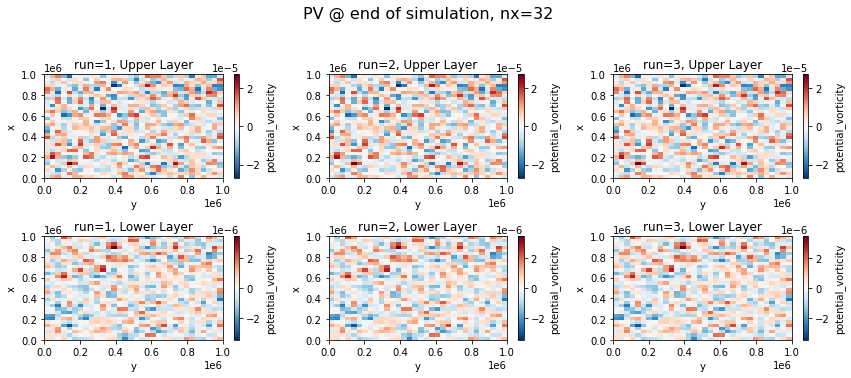

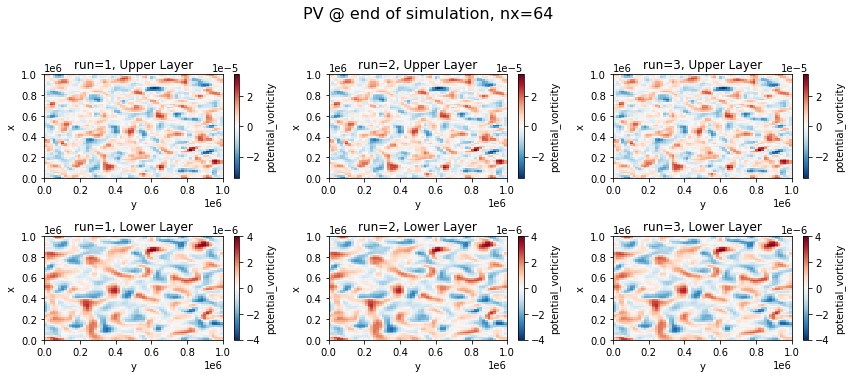

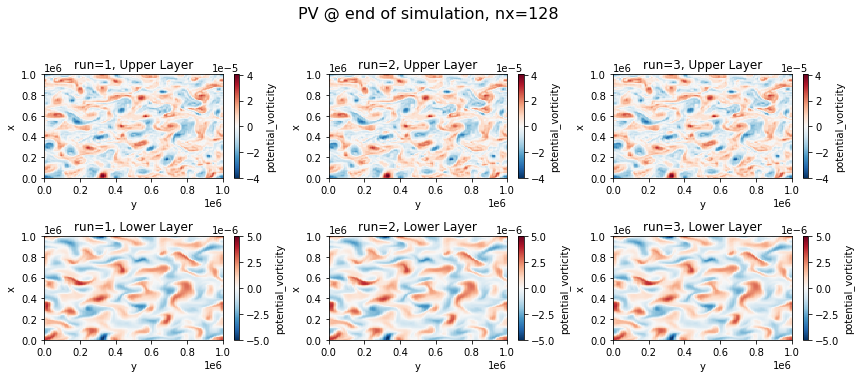

In [54]:
def z_label(z):
    return 'Lower' if z else 'Upper'
    
def plot_heatmaps(fn, title, ns=3):
    for r in runs:
        with figure_grid(2,ns,rowwidth=ns*4,rowheight=2.5) as g:
            g.title(f"{title}, nx={r.coords['x'].size}")
            for z in [0,1]:
                for run in range(ns):
                    fn(r,z).plot(ax=g.next(title=f"run={run+1}, {z_label(z)} Layer"))
                    
                    
plot_heatmaps(lambda r,z: r.isel(dict(run=run, time=-1, z=z)).potential_vorticity,
             "PV @ end of simulation")

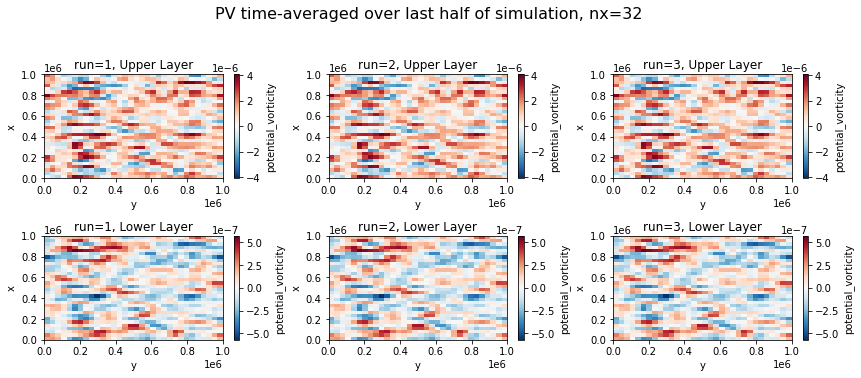

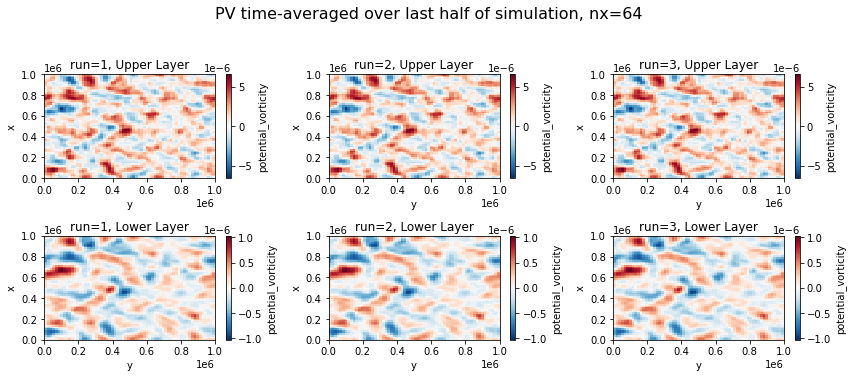

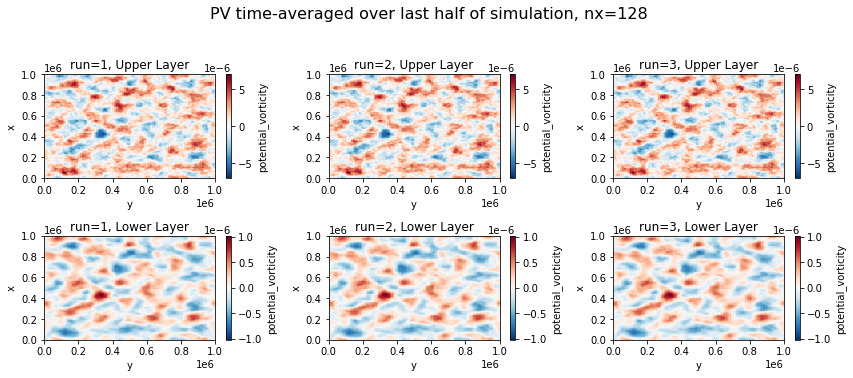

In [55]:
plot_heatmaps(
    lambda r,z: r.isel(dict(run=run, time=slice(r.coords['time'].size//2, None), z=z)).potential_vorticity.mean(dim=('time')),
    "PV time-averaged over last half of simulation"
)

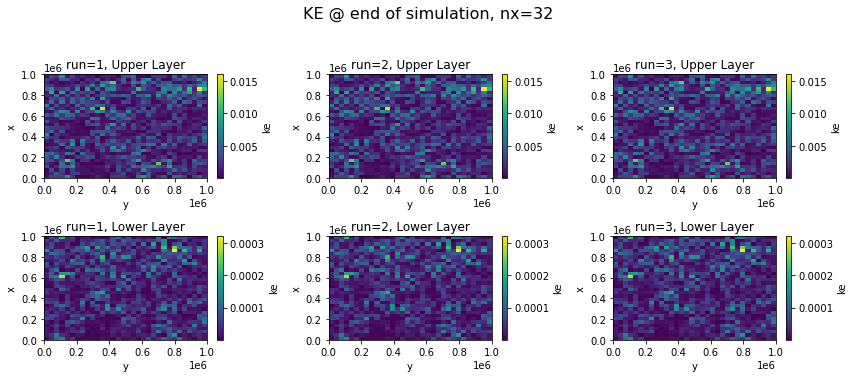

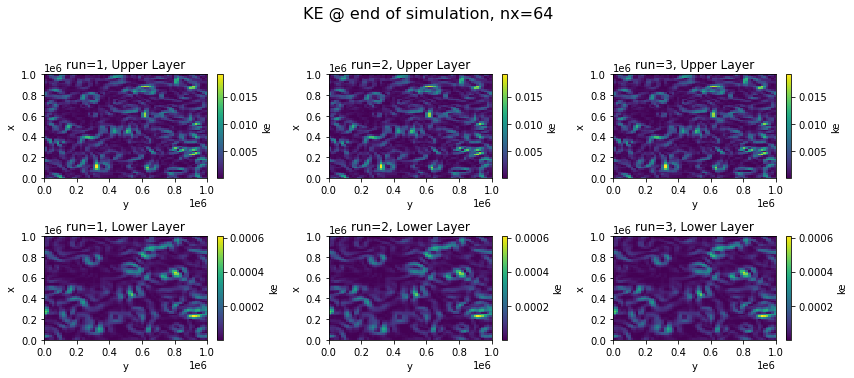

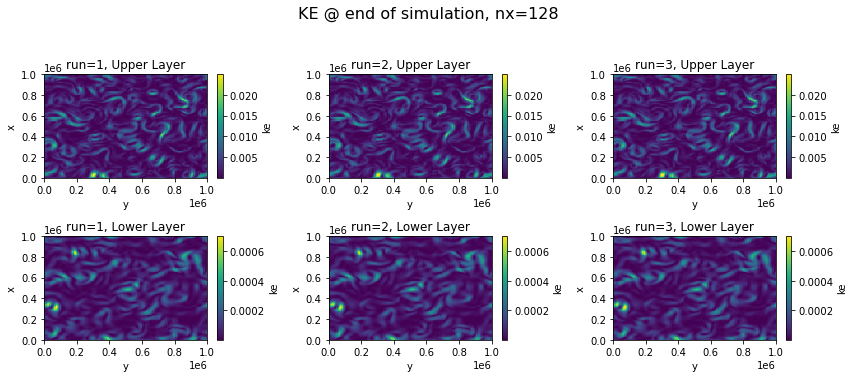

In [56]:
plot_heatmaps(
    lambda r,z: r.isel(dict(run=run, time=-1, z=z)).ke,
    "KE @ end of simulation"
)

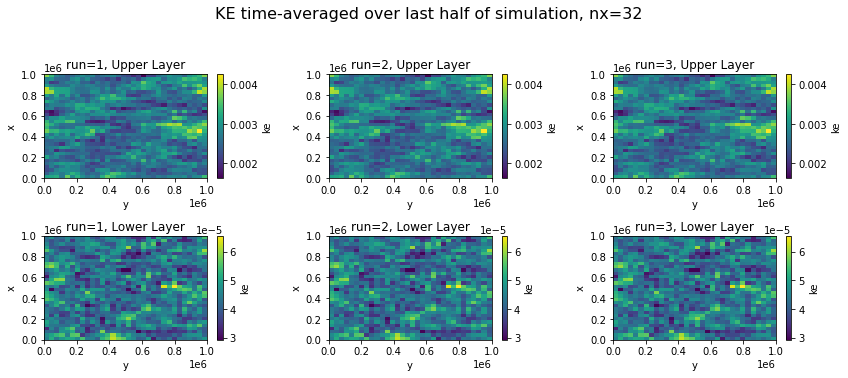

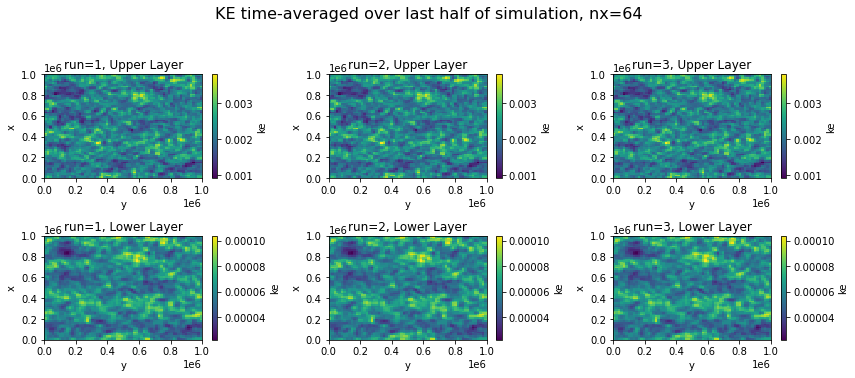

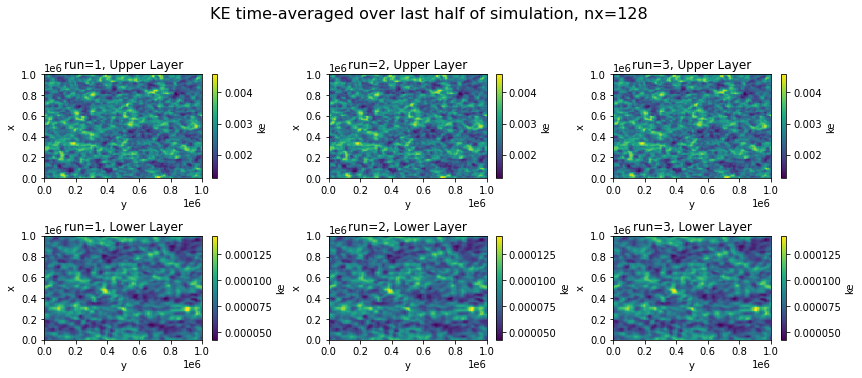

In [57]:
plot_heatmaps(
    lambda r,z: r.isel(dict(run=run, time=slice(r.coords['time'].size//2, None), z=z)).ke.mean(dim=('time')),
    "KE time-averaged over last half of simulation"
)

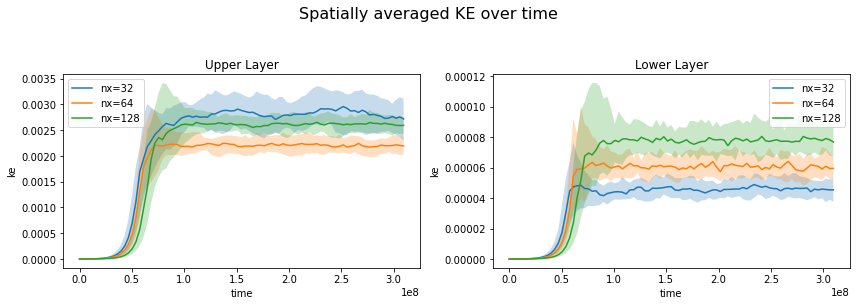

In [29]:
def spatially_averaged(q, r, z, label):
    avg = r.isel(dict(z=z))[q].mean(dim=('x','y'))
    med = avg.quantile(.5, dim='run')
    lo = avg.quantile(.05, dim='run')
    hi = avg.quantile(.95, dim='run')
    med.plot(label=label)
    plt.fill_between(avg.coords['time'], lo, hi, alpha=0.25)

with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged KE over time")
    for z in range(2):
        g.next()
        for r in runs:
            spatially_averaged('ke', r, z, f"nx={r.coords['x'].size}")
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

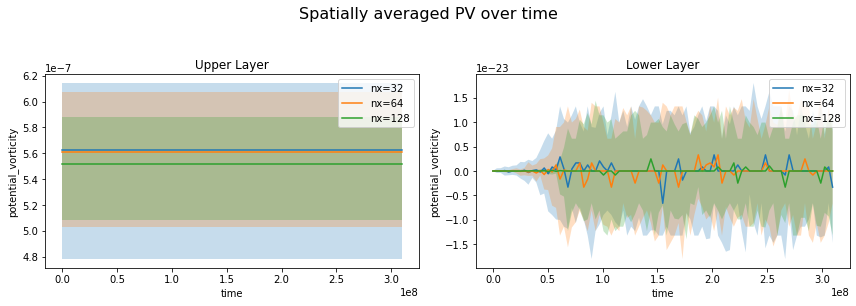

In [30]:
with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged PV over time")
    for z in range(2):
        g.next()
        for r in runs:
            spatially_averaged('potential_vorticity', r, z, f"nx={r.coords['x'].size}")
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

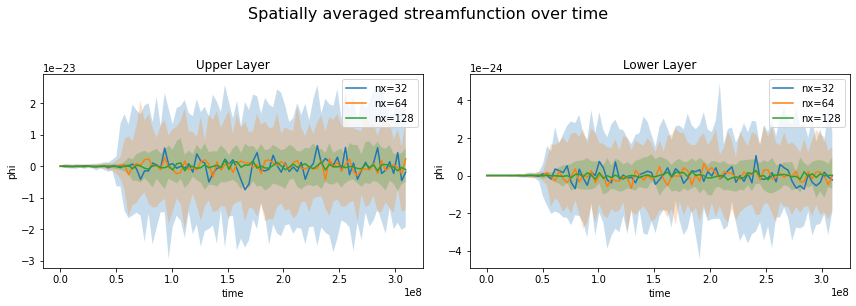

In [31]:
with figure_grid(1,2,rowheight=4) as g:
    g.title("Spatially averaged streamfunction over time")
    for z in range(2):
        g.next()
        for r in runs:
            spatially_averaged('phi', r, z, f"nx={r.coords['x'].size}")
        plt.legend()
        plt.title(f"{z_label(z)} Layer")

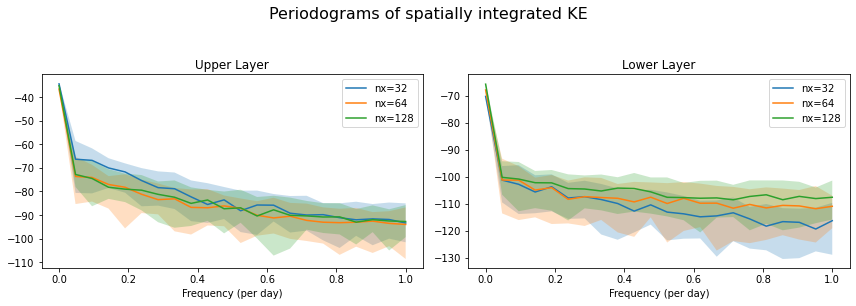

In [32]:
from numpy.fft import fft, fft2, ifft2
def periodogram_ts(ts, start = 0):
    n = ts.shape[1]
    if isinstance(start, float):
        start = int(n * start)
    n = n - start
    vals = (1 / n * abs(fft(ts[:, start: ], axis=1) ** 2))
    return [
         np.percentile(vals, pct, axis=0)[:n//2]
        for pct in [5,50,95]
    ]

def periodogram_plot(r, q, z, **kw):
    nt = r.coords['time'].size
    lo, med, hi = periodogram_ts(
        r.isel(dict(z=z))[q].mean(dim=('x','y')),
        0.5
    )
    freqs = np.linspace(0, 1, med.shape[0])
    plt.plot(freqs, 10 * np.log10(med), **kw)
    plt.fill_between(freqs, 10*np.log10(lo),10*np.log10(hi), alpha=0.25)       
    plt.xlabel("Frequency (per day)")
    
with figure_grid(1,2,rowheight=4) as g:
    g.title("Periodograms of spatially integrated KE")
    for z in [0,1]:
        g.next(title=f"{z_label(z)} Layer")
        for r in runs:
            periodogram_plot(r, 'ke', z, label=f"nx={r.coords['x'].size}")
            plt.legend()

In [133]:
from pyqg.diagnostic_tools import calc_ispec
 
def energy_budget(run_dir):
    with open(f"{run_dir}/../params.json", 'r') as f:
        m = pyqg.QGModel(log_level=0, **json.load(f))

    def get_diagnostic(s):
        return np.load(f"{run_dir}/diagnostics/{s}.npy")
    
    KE1spec, KE2spec = get_diagnostic('KEspec')
    k, KE1spec = calc_ispec(m, KE1spec)
    k, KE2spec = calc_ispec(m, KE2spec)
    ke_spectrum = k, np.stack((KE1spec, KE2spec))
    
    ebud = [get_diagnostic('APEgenspec') / m.M**2,
            get_diagnostic('APEflux')/ m.M**2,
            get_diagnostic('KEflux')/ m.M**2
            -m.rek * m.del2 * get_diagnostic('KEspec')[1]]
    ebud.append(-np.stack(ebud).sum(axis=0))
    ebud = [calc_ispec(m, term)[1] for term in ebud]
    ebud = np.stack(ebud)

    return ke_spectrum, ebud

In [184]:
def plot_energy_budgets(ds):
    ke_specs = []
    ebuds = []
    for i in run_idxs:
        ke_spec, ebud = energy_budget(f"{ds}/pyqg_runs/{i}")
        k, ke_spec = ke_spec
        ke_specs.append(ke_spec)
        ebuds.append(ebud)
    ke_specs = np.stack(ke_specs)
    ebuds = np.stack(ebuds)
    kmin, kmax = 0, 1e-3
    return plot_energy_budget(ke_specs, ebuds, k)

def plot_energy_budget(ke_spec, ebud, k):
    mean_kespec = np.mean(ke_spec, axis=0)
    mean_ebud = np.mean(ebud, axis=0)
    
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(121)
    ax1.loglog(k, mean_kespec.T, '.-')
    ax1.loglog(k, 2 * (k ** -3) * (ke_spec.sum() / (k ** -3).mean()), '0.5', label='$k^{-3}$')

    ax1.legend(['upper layer', 'lower layer', "$k^{-3}$"], loc='best')
    ax1.set_xlabel(r'k (m$^{-1})$')
    ax1.set_ylabel(r'$m^3 s^{-2}$')
    ax1.set_title('Kinetic Energy Spectrum')
    ax1.set_xlim(3e-6, 5e-4)
    ax1.set_ylim(1e-43, 1e-4)
    
    ax2 = fig.add_subplot(122)
    ax2.semilogx(k, mean_ebud.T, '-*')
    ax2.legend(['APE gen', 'APE flux', 'KE flux', 'Bottom drag diss.' , 'Resid.'], loc='best')
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    ax2.set_title("Spectral Energy Budget")
    ax2.set_xlabel(r'$\kappa$ (m$^{-1})$')
    ax2.set_xlim(3e-6, 5e-4)
    ax2.set_ylim(-2e-13, 2e-13)
    
    return fig

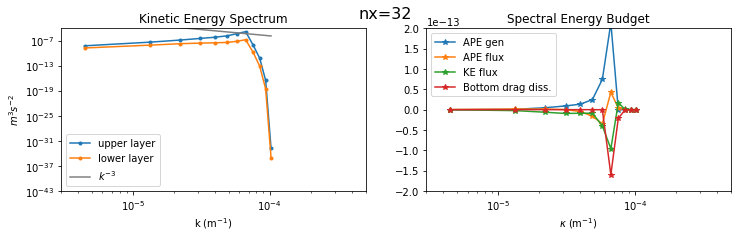

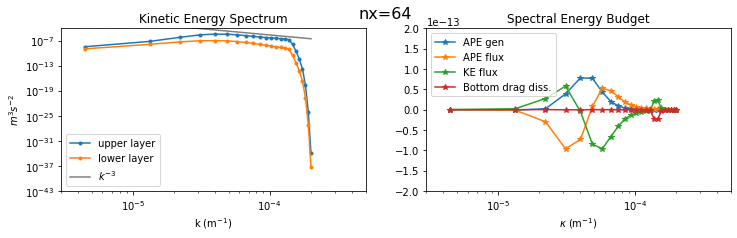

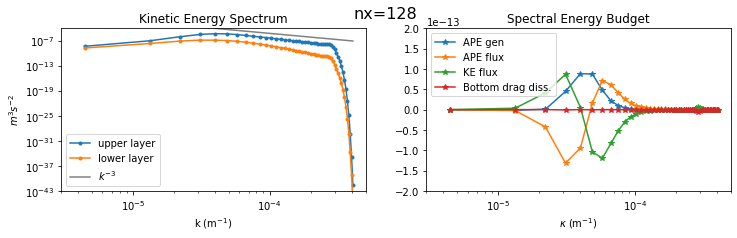

In [185]:
for nx in [32,64,128]:
    plot_energy_budgets(f"/scratch/zanna/data/pyqg/nx{nx}").suptitle(f"nx={nx}", fontsize=16)
    plt.show()